# Import libs

In [75]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [17]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Preprocess 
Downsample , Train-test split

In [18]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [19]:
df_spam = df[df["Category"] == "spam"]
df_spam.shape

(747, 2)

In [20]:
df_ham = df[df["Category"] == "ham"]
df_ham.shape

(4825, 2)

In [21]:
df_ham_down_sampled = df_ham.sample(df_spam.shape[0])
df_ham_down_sampled.shape

(747, 2)

In [22]:
df_balanced = pd.concat([df_ham_down_sampled, df_spam])
df_balanced.shape

(1494, 2)

In [23]:
df_balanced['spam'] = df_balanced["Category"].apply(lambda x : 1 if x == "spam" else 0)
df_balanced['spam'].value_counts()

1    747
0    747
Name: spam, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], test_size=0.2, random_state=42, stratify=df_balanced['spam'])

In [25]:
X_train.head()

1225    You are a winner U have been specially selecte...
4953    Welcome to Select, an O2 service with added be...
1754       Jus came back fr lunch wif my sis only. U leh?
2145    FreeMsg: Hey - I'm Buffy. 25 and love to satis...
4086    Orange brings you ringtones from all time Char...
Name: Message, dtype: object

In [26]:
X_train.shape

(1195,)

In [27]:
X_test.shape

(299,)

In [28]:
y_train.shape

(1195,)

In [29]:
y_test.shape

(299,)

# Practice embedding with BERT

In [31]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

bert_preprocess = hub.KerasLayer("bert_en_uncased_preprocess_3")
bert_encoder = hub.KerasLayer("bert_en_uncased_L-12_H-768_A-12_4")

In [39]:
def get_sentence_embedding(sentences):
    
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [40]:
get_sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351695, -0.5132726 , -0.888457  , ..., -0.7474886 ,
        -0.75314736,  0.91964483],
       [-0.8720835 , -0.5054398 , -0.9444669 , ..., -0.8584752 ,
        -0.7174536 ,  0.8808299 ]], dtype=float32)>

In [42]:
e = get_sentence_embedding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [50]:
cosine_similarity([e[0]] , [e[1]])

array([[0.9911089]], dtype=float32)

In [51]:
cosine_similarity([e[0]] , [e[2]])

array([[0.99540985]], dtype=float32)

In [54]:
cosine_similarity([e[0]] , [e[5]])

array([[0.95718396]], dtype=float32)

In [55]:
cosine_similarity([e[0]] , [e[4]])

array([[0.8933631]], dtype=float32)

In [56]:
cosine_similarity([e[3]] , [e[4]])

array([[0.98720354]], dtype=float32)

# Model - Functional 

In [57]:
#BERT layers
text_input = keras.layers.Input(shape=(), dtype=tf.string, name="text_input")
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

#NN layers
l = keras.layers.Dropout(0.1)(output['pooled_output'])
l = keras.layers.Dense(1, activation='sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [58]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="BinaryAccuracy"),
    tf.keras.metrics.Precision(name="Precision"),
    tf.keras.metrics.Recall(name="Recall")
]

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)

In [59]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
38/38 [==============================] - 456s 12s/step - loss: 0.6370 - BinaryAccuracy: 0.6711 - Precision: 0.6705 - Recall: 0.6739
Epoch 2/5
38/38 [==============================] - 430s 11s/step - loss: 0.5118 - BinaryAccuracy: 0.8192 - Precision: 0.8316 - Recall: 0.8010
Epoch 3/5
38/38 [==============================] - 411s 11s/step - loss: 0.4369 - BinaryAccuracy: 0.8653 - Precision: 0.8507 - Recall: 0.8863
Epoch 4/5
38/38 [==============================] - 436s 11s/step - loss: 0.3941 - BinaryAccuracy: 0.8812 - Precision: 0.8689 - Recall: 0.8980
Epoch 5/5
38/38 [==============================] - 415s 11s/step - loss: 0.3628 - BinaryAccuracy: 0.8745 - Precision: 0.8578 - Recall: 0.8980


In [60]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 85s 9s/step - loss: 0.3088 - BinaryAccuracy: 0.9197 - Precision: 0.8931 - Recall: 0.9530


[0.30880823731422424,
 0.9197324514389038,
 0.893081784248352,
 0.9530201554298401]

In [61]:
y_pred = model.predict(X_test)
y_pred

array([[0.29026666],
       [0.21012321],
       [0.7812507 ],
       [0.8461901 ],
       [0.28097832],
       [0.23263755],
       [0.3389612 ],
       [0.8022563 ],
       [0.5245777 ],
       [0.5245777 ],
       [0.83362174],
       [0.19458571],
       [0.45170227],
       [0.30810842],
       [0.8188367 ],
       [0.24687788],
       [0.04721877],
       [0.6709864 ],
       [0.8560513 ],
       [0.6473556 ],
       [0.08610505],
       [0.76941323],
       [0.8837811 ],
       [0.12985134],
       [0.5458669 ],
       [0.1092639 ],
       [0.92178077],
       [0.77124584],
       [0.12060389],
       [0.77604616],
       [0.6690471 ],
       [0.8985118 ],
       [0.44174078],
       [0.8213501 ],
       [0.8486233 ],
       [0.720039  ],
       [0.5426673 ],
       [0.9062923 ],
       [0.29729685],
       [0.21127671],
       [0.5425793 ],
       [0.30215445],
       [0.25827527],
       [0.6501658 ],
       [0.15355965],
       [0.12007484],
       [0.20135981],
       [0.374

In [64]:
y_pred = y_pred.flatten()
y_pred[0:5]

array([0.29026666, 0.21012321, 0.7812507 , 0.8461901 , 0.28097832],
      dtype=float32)

In [67]:
y_pred = np.round(y_pred)
y_pred[0:5]

array([0., 0., 1., 1., 0.], dtype=float32)

In [70]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[133,  17],
       [  7, 142]], dtype=int64)

Text(33.0, 0.5, 'Truth')

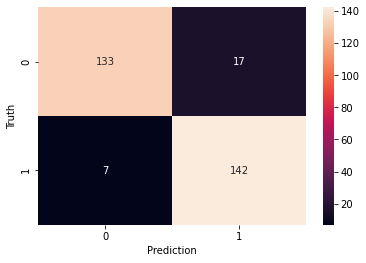

In [73]:
sns.heatmap(cm, fmt='d', annot=True)
plt.xlabel("Prediction")
plt.ylabel("Truth")

In [76]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       150
           1       0.89      0.95      0.92       149

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299

